CMSC320 Final Project
----------

**Data Collection**

To perform any data science analysis we first need to find a dataset. For this project I have decided to use match history data from the game League of Legends, which is a Multiplayer Online Battle Arena (MOBA) produced by Riot Games. So how will we go about collecting this data? Riot is nice enough to provide us with a set of API endpoints that, using carefully constructed requests, can get us a sample of match history data across all ranks of the game. The process for gathering this data isn't quite as nice as just sending a "give me all of your matches" request to the appropriate endpoint however because the only way to request match information is to know the matchID (an identifier used to query for matches) beforehand. So how do we go about getting matchID's you ask, well the easiet method is to already know an accountID and request its match history.


Riot has an endpoint called getLeagueEntries that allows for the requesting of every single player in a ranked division. All you need to do is make a request to ```/lol/league/v4/entries/{queue}/{tier}/{division}```, then fetch the puuIDs of each individual player and using another endpoint, ```/lol/match/v5/matches/by-puuid/{puuid}/ids```, we can get the matches. Using this method we have to worry about double counting matches because each match has 10 players involved who will each have this match as part of their match history. The Riot API is also rate limited, so performing this method, which is request heavy, will take an extended period of time to complete. Therefore after we complete the dataset the first time, we will save it locally so that later operations can be performed much much faster. 

In [178]:
import requests
import json
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

The Riot API also requires a developer key to be able to access the information which must be refreshed every 24 hours to continue requesting data. These keys are can be aquired from the riot developer portal linked here: ```https://developer.riotgames.com/``` as long as you have a Riot account. In order to receive an API key the application that it is to be used for must be submitted through the website for review. Assuming that the application passes the review stage you will be given access to generate a personal API key that requires a daily reset to keep giving access.

In [60]:
api_key = "Your Key Goes Here"

The function defined below gets the **puuids** for each of the top 1000 highest rated players in the North American server. It is important to realize that if you run this code to try and follow along with this tutorial you will not get the same data as is described here. This is because the **puuids**, **matchIds**, and later the match data itself were all collected from the API on May 15 around noon. The API is updated quite frequently, so by the time you might want to run this the leaderboards as well as the match history of those players whose Id's you collect will likely be very different to what is collected in this notebook. If you do want to run the code for yourself, uncomment the line that runs the function and be prepared to wait for the requests to make their way through the throttle.

In [2]:
def get_high_elo_players():
    chally_root = requests.get(f"https://na1.api.riotgames.com/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5?api_key={api_key}")
    gm_root = requests.get(f"https://na1.api.riotgames.com/lol/league/v4/grandmasterleagues/by-queue/RANKED_SOLO_5x5?api_key={api_key}")

    high_elo_players = []
    puuids = []

    challenger_player_entries = json.loads(chally_root.content)['entries']
    gm_player_entries = json.loads(gm_root.content)['entries']

    for player in challenger_player_entries:
        high_elo_players.append(player['summonerName'])
    for player in gm_player_entries:
        high_elo_players.append(player['summonerName'])
        
    for player in high_elo_players:
        # print(f"Requesting puuid for: {player}")
        summoner_root = requests.get(f"https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/{player}?api_key={api_key}")
        if summoner_root.status_code == 429: # Check to see if we are rate limited
            # print("Sleeping for two minutes to avoid rate limits")
            time.sleep(120) # Sleep for two minutes if we are rate limited   
            summoner_root = requests.get(f"https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/{player}?api_key={api_key}")
            puuids.append(json.loads(summoner_root.content)['puuid']) # set the player to its puuid so that we now have a list of puuids
        elif summoner_root.status_code == 404:
            continue
        else:
            puuids.append(json.loads(summoner_root.content)['puuid']) # set the player to its puuid so that we now have a list of puuids
            # print(puuids)
    return puuids     
    # Now we have a list of puuids for high ranking players
    # Lets store these puuids in a file so that we dont have to get rate limited collecting them again
    # File where the requests are stored 
    
# Uncomment me if you want to run this function!    
# player_puuids = get_high_elo_players()

With the above code now run we want to store the list of ids so that we don't need to go through the trouble of waiting on API throttling again. The code below, if uncommented and ran, will save the list of puuids as a JSON file on the local computer. This way with local storage we have much faster access to our list of players.

In [55]:
# print(player_puuids)
# with open('player_puuids.json', 'w') as f:
#     json.dump(player_puuids, f)

Now we have a json file that contains 992 puuids for players in the top two ranked brackets. For each of those players we want to get their match history for the current season. The code below, if the run command is uncommented, goes through each of the stored puuids and gets the most recent 100 matches for each of the players. The reason that we only get the ids for the most recent 100 matches rather than all of those available for each player's match history is because we want our match dataset to be as close to the current patch as possible. League is updated with a balance patch every two weeks, some having more wideranging or impactful changes than others. The largest patches are the start of season patch for each year. It is because of this that we want all of the games that we look at for our analysis to be as close to the same patch as possible to avoid having to concern ourselves with changes made in between games. With more time and computing power we would instead get the whole match history anyway and just perform the same analysis patch by patch so that we could see if any trends immerged over the course of many balance patches. However, because of the aformentioned rate limiter on our requests we don't have the time to get all of the match data required for that kind of analysis. Therefore we will only look at the most recent 100 games to ensure that they are within the current season and were played as close in time to each other as possible. 

In [227]:
def get_matches(puuid, start_idx, matches):
    puuid_matches = []
    matches_root = requests.get(f"https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?type=ranked&start={start_idx}&count=100&api_key={api_key}")
    if(matches_root.status_code == 429):
        print("Sleeping for two minutes to avoid rate limits")
        time.sleep(120) # Sleep for two minutes if we are rate limited   
        matches_root = requests.get(f"https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?type=ranked&start={start_idx}&count=100&api_key={api_key}")
        puuid_matches.extend(json.loads(matches_root.content)) # append the list of matchIds so that we have a list of matches
    elif matches_root.status_code == 404 | matches_root.status_code == 503:
        return
    else:
        # print(json.loads(matches_root.content))
        if (len(json.loads(matches_root.content)) == 0):
            return
        else:
            puuid_matches.extend(json.loads(matches_root.content)) # append the list of matchIds so that we have a list of matches
            # get_matches(puuid, start_idx + 100, matches) This line should be added to get all matches, but since we are trying to make sure that we stay near the current
            # patch we only want the most recent 100 games from all players
    matches.extend(puuid_matches)

# Uncomment me to run and get the list of matchIds!
# Open the file and grab the json data
# with open('player_puuids.json', 'r') as access_json:
#     file_access = json.load(access_json)


# matches = [] 
# for puuid in file_access: # For each of the stored puuids get their match history for the season
#     get_matches(puuid, 0, matches)
#     print(f"Got matches from {puuid}")
    
# print(matches)

The code below just removes the duplicate matchIds from our list since more than one player likely played in the same match and we don't want to double count data. and then counts the number of unique matches that we have access to so that we can determine a proper sample size.

In [7]:
matches = list(dict.fromkeys(matches))

In [9]:
print(len(matches))

37287


This gets us 37287 unique matchId's of which we will sample 20,000 of them. It would be better to just get the match data for all of the available matches however that would take too much time for this project because of the rate limiting. The code below also stores the list of matchIds as another JSON file so that we don't have to collect them again from the API whenever we come back to perform analysis.

In [92]:
# Uncomment me to store the matchIds as a JSON file!
# with open('match_ids.json', 'w') as f:
#     json.dump(matches, f)

Get the stored matchId's and sample 20,000 of them at random. Then get the match data from the api for each of the sampled matches. 20,000 matches was the highest number that we had the time to be rate limited for in the scope of this tutorial. However your analysis would likely improve substantially if you included all of the match data and redid the work we will perform later.

In [12]:
#Open the file and grab the json data
with open('match_ids.json', 'r') as match_ids_json:
    match_ids = json.load(match_ids_json)
    
    
# Now we have a new list of matchIds, unfortunately we dont have the 100 hours necessary to request the match data for all 300 thousand matchIds at our disposal
# Therefore we will take a random sample of these ids to use as our set
sample_match_ids = random.sample(match_ids, 20000) # We use 6000 matches because that takes 2 hours to request, a little easier on my time frame
# sample_match_ids

The code below gets the match data for each of our stored matchIds from the Riot API.

In [228]:
def get_match_data(match_id, match_data_list):
    match_data_root = requests.get(f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}?api_key={api_key}")
    if(match_data_root.status_code == 429):
        print("Sleeping for two minutes to avoid rate limits")
        time.sleep(120) # Sleep for two minutes if we are rate limited   
        match_data_root = requests.get(f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}?api_key={api_key}")
        match_data_list.append(json.loads(match_data_root.content)) # append the list of matchIds so that we have a list of matches
    else:
        match_data_list.append(json.loads(match_data_root.content)) # append the list of matchIds so that we have a list of matches

# Uncomment me to get the match data for each of the matchIds stored in the file!
# match_data_list = []
# i = 1
# for match_id in sample_match_ids:
#     print(f"Getting match data for: {match_id}. Match #: {i}")
#     get_match_data(match_id, match_data_list)
#     i = i+1

In [63]:
len(match_data_list)

20000

If we attempted to store the current sample set of match data to a JSON file right now it would not be useable for us, and certainly opening it could cause a crash. This is because the JSON file format has a maximum number of characters that each file can contain. In the case of our match data, because the information given to us for each match is so large we are not able to store all 20,000 of our points in the same file. After some testing we found that storing 5,000 matches to a file is a good number for using as few files as possible while also preserving performance. Therefore we will break the data up into four equally sized quarters of the list and then store each to a separate JSON file.

In [93]:
match_data_list[0]

length = len(match_data_list) # Get the middle index for the whole list
middle_index = length//2

first_half = match_data_list[:middle_index] # Make halfs
second_half = match_data_list[middle_index:]

length = len(first_half) # Get the middle index for the halfs
middle_index = length//2
first_quarter = first_half[:middle_index] # Get quarters
second_quarter = first_half[middle_index:]
third_quarter = second_half[:middle_index]
fourth_quarter = second_half[middle_index:]

# Store the lists as JSON files
# Uncomment me if you want to store the match data as JSON!
# with open('match_data_first_quarter.json', 'w') as f:
#     json.dump(first_quarter, f)
# with open('match_data_second_quarter.json', 'w') as f:
#     json.dump(second_quarter, f)
# with open('match_data_third_quarter.json', 'w') as f:
#     json.dump(third_quarter, f)
# with open('match_data_fourth_quarter.json', 'w') as f:
#     json.dump(fourth_quarter, f)

NameError: name 'match_data_list' is not defined

Now that we have stored our match data to file we don't need to use the API anymore. All of the rest of our analysis will be done using the information that we have gathered in the above sections. The code bellow allows us to get back the data that we saved to file and recollect the points into one list.

In [ ]:
with open('match_data_first_quarter.json', 'r') as first_quarter_json:
    match_data_first_quarter = json.load(first_quarter_json)
with open('match_data_second_quarter.json', 'r') as second_quarter_json:
    match_data_second_quarter = json.load(second_quarter_json) 
with open('match_data_third_quarter.json', 'r') as third_quarter_json:
    match_data_third_quarter = json.load(third_quarter_json)
with open('match_data_fourth_quarter.json', 'r') as fourth_quarter_json:
    match_data_fourth_quarter = json.load(fourth_quarter_json)
 

In [ ]:
match_data = match_data_first_quarter + match_data_second_quarter + match_data_third_quarter + match_data_fourth_quarter # Puts the sections back into one list

**Data Processing**

Now that we have collected our data its time to move on to the second stage of the Data Science pipeline, processing. In this stage we will perform try to clean up the data set that we just aquired to make it more legible to humans, and also for easily calculated on for our analysis. As an example of why we need this step, this is what the dataframe looks like if we pass our data into pandas immediately without any cleanup:

In [21]:
pd.DataFrame(match_data)

,metadata,info
0,"{'dataVersion': '2', 'matchId': 'NA1_429556395...","{'gameCreation': 1651517705000, 'gameDuration'..."
1,"{'dataVersion': '2', 'matchId': 'NA1_428842422...","{'gameCreation': 1650924942000, 'gameDuration'..."
2,"{'dataVersion': '2', 'matchId': 'NA1_427481674...","{'gameCreation': 1649743078000, 'gameDuration'..."
3,"{'dataVersion': '2', 'matchId': 'NA1_430538410...","{'gameCreation': 1652394654000, 'gameDuration'..."
4,"{'dataVersion': '2', 'matchId': 'NA1_428042450...","{'gameCreation': 1650243429000, 'gameDuration'..."
...,...,...
19995,"{'dataVersion': '2', 'matchId': 'NA1_430127003...","{'gameCreation': 1652043222000, 'gameDuration'..."
19996,"{'dataVersion': '2', 'matchId': 'NA1_427277689...","{'gameCreation': 1649573612000, 'gameDuration'..."
19997,"{'dataVersion': '2', 'matchId': 'NA1_430475196...","{'gameCreation': 1652325533000, 'gameDuration'..."
19998,"{'dataVersion': '2', 'matchId': 'NA1_425927630...","{'gameCreation': 1648431933000, 'gameDuration'..."


Clearly while the above table technically contains all of the data that we need it isnt legible at all, and its format makes performing calucaltions on the data quite complicated. Therefore we need to clean it up. We do this by removing unecessary data and creating descriptive columns that only contain one piece of information rather than a collection of disparate points. The code below takes our list of data and extracts the relevant information. In this case that is the characters picked for each team, the winning team, the game duration, and the game version.

In [4]:
match_ids = []
team1_champs = []
team2_champs = []
team1_win = []
game_duration = []
game_version = []

for match in match_data:
    
    # If something went wrong with the data, skip it
    if ('status' in match):
        continue
    
    # Get the necessary aspects of the data
    match_id = match['metadata']['matchId']
    participants = match['info']['participants']
    duration = match['info']['gameDuration']
    version = match['info']['gameVersion']
    
    team1 = []
    team2 = []
    win = participants[0]['win']
    for i in range(0,10): # For each player in the game, add their chosen character to the list of champs picked for their respective team
        champ = participants[i]['championName']
        if i < 5:
            team1.append(champ)
        else:
            team2.append(champ)
            
    # Append the necessary information to lists and make a new dataframe out of it
    match_ids.append(match_id)
    team1_champs.append(team1)
    team2_champs.append(team2)
    team1_win.append(win)
    game_duration.append(duration)
    game_version.append(version)
    
d = {'match_id':match_ids,'team1_champs':team1_champs,'team2_champs':team2_champs,'team1_win':team1_win,'duration':game_duration, 'version':game_version}
match_df = pd.DataFrame(d)

In [23]:
match_df

,match_id,team1_champs,team2_champs,team1_win,duration,version
0,NA1_4295563955,"[Fiora, Kindred, Orianna, Lucian, Renata]","[Gragas, Viego, Akshan, Swain, Bard]",True,1650,12.8.437.6765
1,NA1_4288424228,"[Sion, Qiyana, Galio, Kaisa, Blitzcrank]","[DrMundo, TwistedFate, LeeSin, Aphelios, Senna]",False,1800,12.7.433.4138
2,NA1_4274816741,"[Ahri, Zed, Teemo, Ezreal, Karma]","[Cassiopeia, LeeSin, Kaisa, Lucian, Nami]",False,1442,12.6.432.1258
3,NA1_4305384100,"[Aatrox, Lillia, Samira, KogMaw, Yuumi]","[Kayle, Olaf, Irelia, Aphelios, Lulu]",True,1731,12.9.439.127
4,NA1_4280424504,"[Camille, Veigar, LeeSin, Jinx, Nautilus]","[Viego, Irelia, Nidalee, Samira, Renata]",True,1750,12.7.433.4138
...,...,...,...,...,...,...
19995,NA1_4301270033,"[Camille, Viego, Akali, Yasuo, Lux]","[Poppy, Graves, Ahri, Seraphine, Lulu]",True,1565,12.8.437.6765
19996,NA1_4272776890,"[Garen, Xayah, TwistedFate, Poppy, Sona]","[Gangplank, Singed, Ahri, Jhin, Morgana]",True,1452,12.6.432.1258
19997,NA1_4304751961,"[Gangplank, Khazix, Galio, Ezreal, Zyra]","[TahmKench, Ekko, Qiyana, Xayah, Soraka]",False,2385,12.9.439.127
19998,NA1_4259276308,"[Kennen, Zac, Yasuo, Kaisa, Janna]","[Aatrox, Qiyana, Karthus, Jinx, Nami]",False,2025,12.5.425.9171


It is important to note that just because we feel that the data is cleaned up for now, doesn't mean that we will never be doing any more manipulation of the table in the future. The needs of a Data Scientist changes as the project progresses and new information or insights are gleaned from our analysis. In the case that we didn't include something that we needed from the dataset, or that some column needs to be broken up further, we are perfectly capable of performing that processing when the time calls for it. For example, it is entirely possible that we will want to convert the columns that contain the characters picked for each team into several dummy columns assigned to each character that only contain a 1 or 0 to indicate whether a team picked that character. To a human this might seem like a strange choice as it will make the table larger and a little harder to read, but for some computer analysis it makes things much easier.

**Exploratory Analysis**

The next step in our pipeline is the exploratory analysis stage. In this section we will perform some simple analysis as well as visualization techniques in order to look for patterns or otherwise interesting phenomina in our data. This initial analyisis will hopefully illuminate some correlations or other patterns that indicate the direction that we should head for our more in depth analysis. The first thing that we are going to look at is the winrate for each of the characters given our sample, as well as how their winrate changes given the game duration. This should give us some idea as to the general classes of characters, that being those that are strong early and fall off later into the game, midrange spiking characters, scaling carries, and anyother non-conforming character. The code below does just that, it collects the number of wins and the number of games played for each character for each of the time intervals.

In [5]:
champ_dict_total = {}
champ_dict_wins = {}

champ_dict_less_than_5 = {}
champ_dict_less_than_5_wins = {}

champ_dict_5_to_15 = {}
champ_dict_5_to_15_wins = {}

champ_dict_15_to_20 = {}
champ_dict_15_to_20_wins = {}

champ_dict_20_to_25 = {}
champ_dict_20_to_25_wins = {}

champ_dict_25_to_30 = {}
champ_dict_25_to_30_wins = {}

champ_dict_30_to_35 = {}
champ_dict_30_to_35_wins = {}

champ_dict_35_to_40 = {}
champ_dict_35_to_40_wins = {}

champ_dict_greater_than_40 = {}
champ_dict_greater_than_40_wins = {}

for row in match_df.iterrows():
    # For each match, add the number of wins and games to the correct dictionary based on the game duration
    id = row[0]
    team1_champs = row[1]['team1_champs']
    team2_champs = row[1]['team2_champs']
    duration = row[1]['duration']
    version = row[1]['version']
    
    # Add the current champion to the dictionary for total wins and games
    for champ in team1_champs:
        if champ in champ_dict_total:
            champ_dict_total[champ] = champ_dict_total[champ] + 1
            
            if row[1]['team1_win'] == True:
                champ_dict_wins[champ] = champ_dict_wins[champ] + 1
        else:
            champ_dict_total[champ] = 1
            if row[1]['team1_win'] == True:
                champ_dict_wins[champ] = 1
            else:
                champ_dict_wins[champ] = 0
        
        # If statements for determining dict insertion based on game time      
        if duration < 300: # If game time less than 5 mins
            if champ in champ_dict_less_than_5:
                champ_dict_less_than_5[champ] = champ_dict_less_than_5[champ] + 1

                if row[1]['team1_win'] == True:
                    champ_dict_less_than_5_wins[champ] = champ_dict_less_than_5_wins[champ] + 1
            else:
                champ_dict_less_than_5[champ] = 1
                if row[1]['team1_win'] == True:
                    champ_dict_less_than_5_wins[champ] = 1
                else:
                    champ_dict_less_than_5_wins[champ] = 0
                    
        elif duration < 900: # If game time less than 15 mins
            if champ in champ_dict_5_to_15:
                champ_dict_5_to_15[champ] = champ_dict_5_to_15[champ] + 1

                if row[1]['team1_win'] == True:
                    champ_dict_5_to_15_wins[champ] = champ_dict_5_to_15_wins[champ] + 1
            else:
                champ_dict_5_to_15[champ] = 1
                if row[1]['team1_win'] == True:
                    champ_dict_5_to_15_wins[champ] = 1
                else:
                    champ_dict_5_to_15_wins[champ] = 0
        

        elif duration < 1200: # If game time less than 20 mins
            if champ in champ_dict_15_to_20:
                champ_dict_15_to_20[champ] = champ_dict_15_to_20[champ] + 1

                if row[1]['team1_win'] == True:
                    champ_dict_15_to_20_wins[champ] = champ_dict_15_to_20_wins[champ] + 1
            else:
                champ_dict_15_to_20[champ] = 1
                if row[1]['team1_win'] == True:
                    champ_dict_15_to_20_wins[champ] = 1
                else:
                    champ_dict_15_to_20_wins[champ] = 0

        elif duration < 1500: # If game time less than 25 mins
            if champ in champ_dict_20_to_25:
                champ_dict_20_to_25[champ] = champ_dict_20_to_25[champ] + 1

                if row[1]['team1_win'] == True:
                    champ_dict_20_to_25_wins[champ] = champ_dict_20_to_25_wins[champ] + 1
            else:
                champ_dict_20_to_25[champ] = 1
                if row[1]['team1_win'] == True:
                    champ_dict_20_to_25_wins[champ] = 1
                else:
                    champ_dict_20_to_25_wins[champ] = 0

        elif duration < 1800: # If game time less than 30 mins
            if champ in champ_dict_25_to_30:
                champ_dict_25_to_30[champ] = champ_dict_25_to_30[champ] + 1

                if row[1]['team1_win'] == True:
                    champ_dict_25_to_30_wins[champ] = champ_dict_25_to_30_wins[champ] + 1
            else:
                champ_dict_25_to_30[champ] = 1
                if row[1]['team1_win'] == True:
                    champ_dict_25_to_30_wins[champ] = 1
                else:
                    champ_dict_25_to_30_wins[champ] = 0

        elif duration < 2100: # If game time less than 30 mins
            if champ in champ_dict_30_to_35:
                champ_dict_30_to_35[champ] = champ_dict_30_to_35[champ] + 1

                if row[1]['team1_win'] == True:
                    champ_dict_30_to_35_wins[champ] = champ_dict_30_to_35_wins[champ] + 1
            else:
                champ_dict_30_to_35[champ] = 1
                if row[1]['team1_win'] == True:
                    champ_dict_30_to_35_wins[champ] = 1
                else:
                    champ_dict_30_to_35_wins[champ] = 0
                    
        elif duration < 2400: # If game time less than 30 mins
            if champ in champ_dict_35_to_40:
                champ_dict_35_to_40[champ] = champ_dict_35_to_40[champ] + 1

                if row[1]['team1_win'] == True:
                    champ_dict_35_to_40_wins[champ] = champ_dict_35_to_40_wins[champ] + 1
            else:
                champ_dict_35_to_40[champ] = 1
                if row[1]['team1_win'] == True:
                    champ_dict_35_to_40_wins[champ] = 1
                else:
                    champ_dict_35_to_40_wins[champ] = 0
                    
        else:
            if champ in champ_dict_greater_than_40:
                champ_dict_greater_than_40[champ] = champ_dict_greater_than_40[champ] + 1

                if row[1]['team1_win'] == True:
                    champ_dict_greater_than_40_wins[champ] = champ_dict_greater_than_40_wins[champ] + 1
            else:
                champ_dict_greater_than_40[champ] = 1
                if row[1]['team1_win'] == True:
                    champ_dict_greater_than_40_wins[champ] = 1
                else:
                    champ_dict_greater_than_40_wins[champ] = 0
                        
                        
                        
    # Do the same for the characters on team 2, the true false detection will be swapped because a win is now a team1 loss                    
    for champ in team2_champs:
        if champ in champ_dict_total:
            champ_dict_total[champ] = champ_dict_total[champ] + 1
            
            if row[1]['team1_win'] == False:
                champ_dict_wins[champ] = champ_dict_wins[champ] + 1
        else:
            champ_dict_total[champ] = 1
            if row[1]['team1_win'] == False:
                champ_dict_wins[champ] = 1
            else:
                champ_dict_wins[champ] = 0
                
                
        # If statements for determining dict insertion based on game time      
        if duration < 300: # If game time less than 15 mins
            if champ in champ_dict_less_than_5:
                champ_dict_less_than_5[champ] = champ_dict_less_than_5[champ] + 1

                if row[1]['team1_win'] == True:
                    champ_dict_less_than_5_wins[champ] = champ_dict_less_than_5_wins[champ] + 1
            else:
                champ_dict_less_than_5[champ] = 1
                if row[1]['team1_win'] == True:
                    champ_dict_less_than_5_wins[champ] = 1
                else:
                    champ_dict_less_than_5_wins[champ] = 0
                    
        elif duration < 900: # If game time less than 15 mins
            if champ in champ_dict_5_to_15:
                champ_dict_5_to_15[champ] = champ_dict_5_to_15[champ] + 1

                if row[1]['team1_win'] == True:
                    champ_dict_5_to_15_wins[champ] = champ_dict_5_to_15_wins[champ] + 1
            else:
                champ_dict_5_to_15[champ] = 1
                if row[1]['team1_win'] == True:
                    champ_dict_5_to_15_wins[champ] = 1
                else:
                    champ_dict_5_to_15_wins[champ] = 0

        elif duration < 1200: # If game time less than 20 mins
            if champ in champ_dict_15_to_20:
                champ_dict_15_to_20[champ] = champ_dict_15_to_20[champ] + 1

                if row[1]['team1_win'] == True:
                    champ_dict_15_to_20_wins[champ] = champ_dict_15_to_20_wins[champ] + 1
            else:
                champ_dict_15_to_20[champ] = 1
                if row[1]['team1_win'] == True:
                    champ_dict_15_to_20_wins[champ] = 1
                else:
                    champ_dict_15_to_20_wins[champ] = 0

        elif duration < 1500: # If game time less than 25 mins
            if champ in champ_dict_20_to_25:
                champ_dict_20_to_25[champ] = champ_dict_20_to_25[champ] + 1

                if row[1]['team1_win'] == True:
                    champ_dict_20_to_25_wins[champ] = champ_dict_20_to_25_wins[champ] + 1
            else:
                champ_dict_20_to_25[champ] = 1
                if row[1]['team1_win'] == True:
                    champ_dict_20_to_25_wins[champ] = 1
                else:
                    champ_dict_20_to_25_wins[champ] = 0

        elif duration < 1800: # If game time less than 30 mins
            if champ in champ_dict_25_to_30:
                champ_dict_25_to_30[champ] = champ_dict_25_to_30[champ] + 1

                if row[1]['team1_win'] == True:
                    champ_dict_25_to_30_wins[champ] = champ_dict_25_to_30_wins[champ] + 1
            else:
                champ_dict_25_to_30[champ] = 1
                if row[1]['team1_win'] == True:
                    champ_dict_25_to_30_wins[champ] = 1
                else:
                    champ_dict_25_to_30_wins[champ] = 0

        elif duration < 2100: # If game time less than 30 mins
            if champ in champ_dict_30_to_35:
                champ_dict_30_to_35[champ] = champ_dict_30_to_35[champ] + 1

                if row[1]['team1_win'] == True:
                    champ_dict_30_to_35_wins[champ] = champ_dict_30_to_35_wins[champ] + 1
            else:
                champ_dict_30_to_35[champ] = 1
                if row[1]['team1_win'] == True:
                    champ_dict_30_to_35_wins[champ] = 1
                else:
                    champ_dict_30_to_35_wins[champ] = 0
                    
        elif duration < 2400: # If game time less than 30 mins
            if champ in champ_dict_35_to_40:
                champ_dict_35_to_40[champ] = champ_dict_35_to_40[champ] + 1

                if row[1]['team1_win'] == True:
                    champ_dict_35_to_40_wins[champ] = champ_dict_35_to_40_wins[champ] + 1
            else:
                champ_dict_35_to_40[champ] = 1
                if row[1]['team1_win'] == True:
                    champ_dict_35_to_40_wins[champ] = 1
                else:
                    champ_dict_35_to_40_wins[champ] = 0
                    
        else:
            if champ in champ_dict_greater_than_40:
                champ_dict_greater_than_40[champ] = champ_dict_greater_than_40[champ] + 1

                if row[1]['team1_win'] == True:
                    champ_dict_greater_than_40_wins[champ] = champ_dict_greater_than_40_wins[champ] + 1
            else:
                champ_dict_greater_than_40[champ] = 1
                if row[1]['team1_win'] == True:
                    champ_dict_greater_than_40_wins[champ] = 1
                else:
                    champ_dict_greater_than_40_wins[champ] = 0

Now that we have the number of wins and the total number of games played during each time interval, as well as in total, for each character we can calculate the winrates for each of the intervals and graph a few characters winrates over time.

In [6]:
champ_wr = {}
champ_wr_less_than_5 = {}
champ_wr_5_to_15 = {}
champ_wr_15_to_20 = {}
champ_wr_20_to_25 = {}
champ_wr_25_to_30 = {}
champ_wr_30_to_35 = {}
champ_wr_35_to_40 = {}
champ_wr_greater_than_40 = {}

# The code here could use some work as this should be done in one loop rather than one for each time zone
# However figuring out how to deal with characters that dont appear in every interval got complicated
# and at only 159 entries this seemed easier. Dont do this for larger lists

# Calculates the winrate for each champion in each time interval
for champ in champ_dict_total:
    champ_wr[champ] = champ_dict_wins[champ] / champ_dict_total[champ]
for champ in champ_dict_less_than_5:    
    champ_wr_less_than_5[champ] = champ_dict_less_than_5_wins[champ] / champ_dict_less_than_5[champ]
for champ in champ_dict_5_to_15:      
    champ_wr_5_to_15[champ] = champ_dict_5_to_15_wins[champ] / champ_dict_5_to_15[champ]
for champ in champ_dict_15_to_20:
    champ_wr_15_to_20[champ] = champ_dict_15_to_20_wins[champ] / champ_dict_15_to_20[champ]
for champ in champ_dict_20_to_25:
    champ_wr_20_to_25[champ] = champ_dict_20_to_25_wins[champ] / champ_dict_20_to_25[champ]
for champ in champ_dict_25_to_30:
    champ_wr_25_to_30[champ] = champ_dict_25_to_30_wins[champ] / champ_dict_25_to_30[champ]
for champ in champ_dict_30_to_35:
    champ_wr_30_to_35[champ] = champ_dict_30_to_35_wins[champ] / champ_dict_30_to_35[champ]
for champ in champ_dict_35_to_40:
    champ_wr_35_to_40[champ] = champ_dict_35_to_40_wins[champ] / champ_dict_35_to_40[champ]
for champ in champ_dict_greater_than_40:
    champ_wr_greater_than_40[champ] = champ_dict_greater_than_40_wins[champ] / champ_dict_greater_than_40[champ]



In the code below we create a table for the total winrate of each character across all games.

In [199]:
wr_df = pd.DataFrame(
    {'champion': list(champ_wr.keys()),
     'winrate': list(champ_wr.values())
    })
wr_df

,champion,winrate
0,Fiora,0.499542
1,Kindred,0.540304
2,Orianna,0.468217
3,Lucian,0.502731
4,Renata,0.540698
...,...,...
154,Maokai,0.530973
155,Sejuani,0.457317
156,Elise,0.485246
157,Rell,0.542135


Now that we have calculated these winrates, lets see about visualizing them more easily. This will require making a DataFrame for our winrate data associated with each champion as well as some more clean-up to make the graphing go smoother. In the code below we construct a Pandas DataFrame from the winrate data calculated above so that each row is associated with a champion and each of their columns contains the winrate for the given interval.

In [8]:
champs = champ_dict_total.keys()
wr_less_than_5 = []
wr_5_to_15 = []
wr_15_to_20 = []
wr_20_to_25 = []
wr_25_to_30 = []
wr_30_to_35 = []
wr_35_to_40 = []
wr_greater_than_40 = []

for champ in champs:
    if champ in champ_wr_less_than_5:
        wr_less_than_5.append(champ_wr_less_than_5[champ])
    else:
        wr_less_than_5.append(np.nan)

    if champ in champ_wr_5_to_15:
        wr_5_to_15.append(champ_wr_5_to_15[champ])
    else:
        wr_5_to_15.append(np.nan)

    if champ in champ_wr_15_to_20:
        wr_15_to_20.append(champ_wr_15_to_20[champ])
    else:
        wr_15_to_20.append(np.nan)

    if champ in champ_wr_20_to_25:
        wr_20_to_25.append(champ_wr_20_to_25[champ])
    else:
        wr_20_to_25.append(np.nan)

    if champ in champ_wr_25_to_30:
        wr_25_to_30.append(champ_wr_25_to_30[champ])
    else:
        wr_25_to_30.append(np.nan)

    if champ in champ_wr_30_to_35:
        wr_30_to_35.append(champ_wr_30_to_35[champ])
    else:
        wr_30_to_35.append(np.nan)
        
    if champ in champ_wr_35_to_40:
        wr_35_to_40.append(champ_wr_35_to_40[champ])
    else:
        wr_35_to_40.append(np.nan)
        
    if champ in champ_wr_greater_than_40:
        wr_greater_than_40.append(champ_wr_greater_than_40[champ])
    else:
        wr_greater_than_40.append(np.nan)
        
wr_over_time_df = pd.DataFrame(
    {'champion': champs,
     'less_than_5': wr_less_than_5,
     '10': wr_5_to_15,
     '17.5': wr_15_to_20,
     '22.5': wr_20_to_25,
     '27.5': wr_25_to_30,
     '32.5': wr_30_to_35,
     '37.5': wr_35_to_40,
     '42.5': wr_greater_than_40
    })

wr_over_time_df

,champion,less_than_5,10,17.5,22.5,27.5,32.5,37.5,42.5
0,Fiora,0.571429,0.625000,0.526882,0.507463,0.472477,0.457275,0.406667,0.400000
1,Kindred,0.000000,0.500000,0.493506,0.493023,0.513975,0.470284,0.463415,0.566667
2,Orianna,NaN,0.200000,0.463415,0.493976,0.480392,0.523077,0.521739,0.500000
3,Lucian,0.615385,0.550000,0.463964,0.486607,0.486538,0.474898,0.486275,0.333333
4,Renata,0.444444,0.529412,0.521569,0.528029,0.481013,0.514085,0.422535,0.466667
...,...,...,...,...,...,...,...,...,...
154,Maokai,0.500000,0.666667,0.461538,0.385965,0.388889,0.521739,0.187500,0.500000
155,Sejuani,1.000000,0.666667,0.413793,0.489362,0.494505,0.516129,0.333333,0.166667
156,Elise,1.000000,0.200000,0.513514,0.367089,0.478261,0.428571,0.444444,0.200000
157,Rell,0.500000,0.500000,0.510204,0.452632,0.487603,0.616667,0.571429,0.500000


We use the time value in the middle of the interval as the column label because it will make our lives easier once we go to graph our winrates. Now that we have a table of winrates over time we actually want to remove the less_than_5 column. Typical games last anywhere from 20 to 30 minutes and in fact a team cannot even surrender a game until 15 minutes. All of the games that end under 5 minutes are what are called **remakes**. For those games, at least one player never connected to the game, so there is an early surrender vote that can be called to allow the afflicted team to leave early without wasting their time. Therefore these games are essentially duds that should not be counted against a champion because nothing other than an internet connection affect the loss.

In [9]:
wr_over_time_df = wr_over_time_df.drop('less_than_5', 1)

/tmp/ipykernel_50/2331746267.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  wr_over_time_df = wr_over_time_df.drop('less_than_5', 1)


Now our table captures all of the information that we need to plot the winrates over time for each champion. It is worth noting that not every time interval has a winrate for every champion. Even with 20,000 matches of sample data, some characters are picked so rarely that they dont have a recorded game played that ended during every time interval. In those cases we will simply not plot the point for that character for that interval. It doesnt seem to be the case that we can interpolate and guess the winrate during the missing intervals particularly accurately because some characters have winrates over time that have many ups and downs, but since it is our best tool available thats all we have to use. It is also worth stating that for similar reasons the winrate calculated for each time interval is likely to be much less accurate to the population of games containing the character that end during the interval because the sample size for each interval is very small, especially for unlikely game times like greater than 40 minutes. The way to fix this would be to have a larger sample size of games, unfortuantely we were not able to to that for this project.

In order to graph the winrates we still need to do some pre-processing on our table. Given the current organization of the table it would be easy for a human to plot out each of the champion's winrates over time. However for pandas it's a little more difficult. To make this easier we will be using the ```pandas.melt``` function which will take our time interval columns and turn them into entries in the table. This will make each champion have multiple rows asscociated with it, one for each time interval. Below is the code used to melt the table as well as an example of what the new table looks like.

In [10]:
# Melt the dataframe over each champion so that each duration becomes a row
wr_over_time_df = pd.melt(wr_over_time_df,
 ["champion"],
 var_name="duration",
 value_name="winrate")

wr_over_time_df.sort_values(by=["champion"]).head(10)

,champion,duration,winrate
186,Aatrox,17.5,0.507553
345,Aatrox,22.5,0.494460
981,Aatrox,42.5,0.536585
27,Aatrox,10,0.473684
822,Aatrox,37.5,0.544218
663,Aatrox,32.5,0.438878
504,Aatrox,27.5,0.483745
338,Ahri,22.5,0.475594
974,Ahri,42.5,0.272727
497,Ahri,27.5,0.492344


Now that we have our properly melted table of winrates we can plot them:

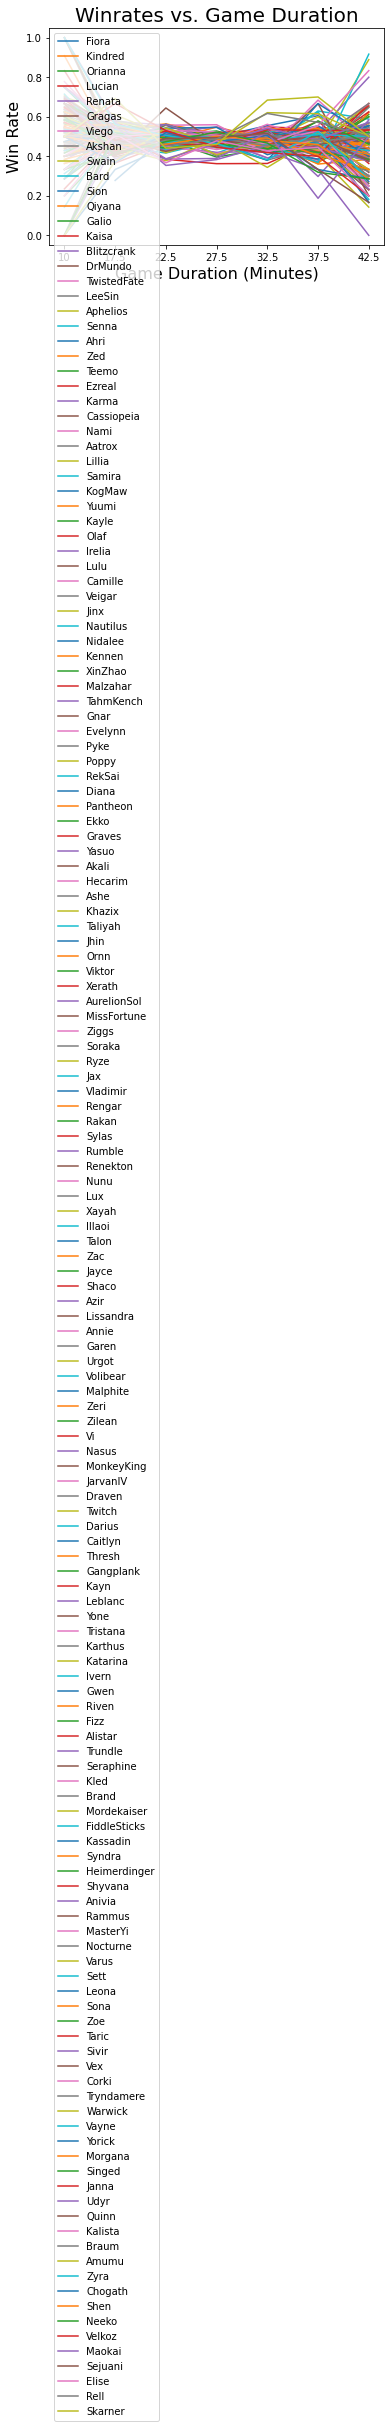

In [11]:
for i in range(0,159):
    champ = list(champs)[i]
    champ_data = wr_over_time_df[wr_over_time_df['champion'] == champ]
    plt.plot('duration', 'winrate', data=champ_data, label = champ)
    

plt.title("Winrates vs. Game Duration", size = 20)
plt.xlabel("Game Duration (Minutes)", size = 16)
plt.ylabel("Win Rate", size = 16)
plt.legend()

Clearly the above graph leads a lot to be desired. For one, having 159 lines all crossing over each other makes it difficult to tell what any individual curve looks like. Another issue is that there are only 10 default colors so you can't tell which curve belongs to which character. And obviously the legend needs work. Therefore we will be plotting the winrates in 10 champion batches. 

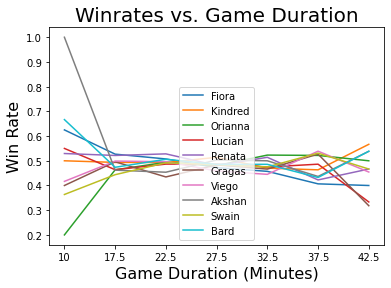

In [12]:
for i in range(0,10):
    champ = list(champs)[i]
    champ_data = wr_over_time_df[wr_over_time_df['champion'] == champ]
    plt.plot('duration', 'winrate', data=champ_data, label = champ)
    

plt.title("Winrates vs. Game Duration", size = 20)
plt.xlabel("Game Duration (Minutes)", size = 16)
plt.ylabel("Win Rate", size = 16)
plt.legend()

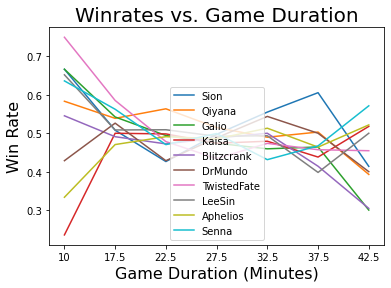

In [13]:
for i in range(10,20):
    champ = list(champs)[i]
    champ_data = wr_over_time_df[wr_over_time_df['champion'] == champ]
    plt.plot('duration', 'winrate', data=champ_data, label = champ)
    

plt.title("Winrates vs. Game Duration", size = 20)
plt.xlabel("Game Duration (Minutes)", size = 16)
plt.ylabel("Win Rate", size = 16)
plt.legend()

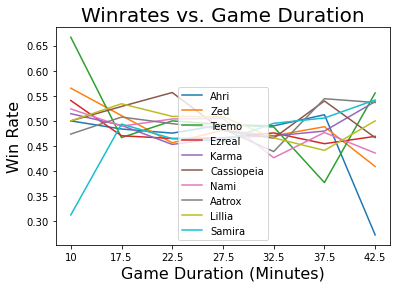

In [14]:
for i in range(20,30):
    champ = list(champs)[i]
    champ_data = wr_over_time_df[wr_over_time_df['champion'] == champ]
    plt.plot('duration', 'winrate', data=champ_data, label = champ)
    

plt.title("Winrates vs. Game Duration", size = 20)
plt.xlabel("Game Duration (Minutes)", size = 16)
plt.ylabel("Win Rate", size = 16)
plt.legend()

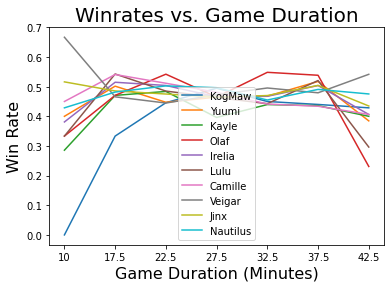

In [15]:
for i in range(30,40):
    champ = list(champs)[i]
    champ_data = wr_over_time_df[wr_over_time_df['champion'] == champ]
    plt.plot('duration', 'winrate', data=champ_data, label = champ)
    

plt.title("Winrates vs. Game Duration", size = 20)
plt.xlabel("Game Duration (Minutes)", size = 16)
plt.ylabel("Win Rate", size = 16)
plt.legend()

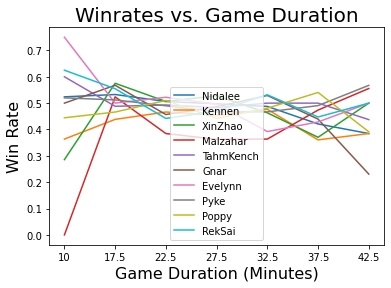

In [16]:
for i in range(40,50):
    champ = list(champs)[i]
    champ_data = wr_over_time_df[wr_over_time_df['champion'] == champ]
    plt.plot('duration', 'winrate', data=champ_data, label = champ)
    

plt.title("Winrates vs. Game Duration", size = 20)
plt.xlabel("Game Duration (Minutes)", size = 16)
plt.ylabel("Win Rate", size = 16)
plt.legend()

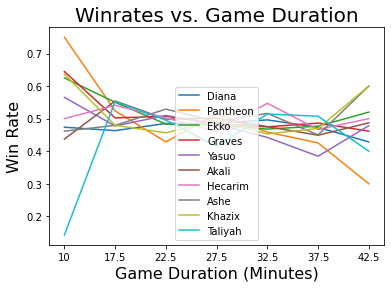

In [17]:
for i in range(50,60):
    champ = list(champs)[i]
    champ_data = wr_over_time_df[wr_over_time_df['champion'] == champ]
    plt.plot('duration', 'winrate', data=champ_data, label = champ)
    

plt.title("Winrates vs. Game Duration", size = 20)
plt.xlabel("Game Duration (Minutes)", size = 16)
plt.ylabel("Win Rate", size = 16)
plt.legend()

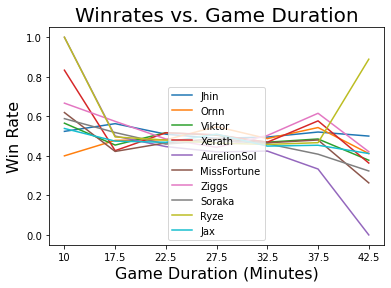

In [18]:
for i in range(60,70):
    champ = list(champs)[i]
    champ_data = wr_over_time_df[wr_over_time_df['champion'] == champ]
    plt.plot('duration', 'winrate', data=champ_data, label = champ)
    

plt.title("Winrates vs. Game Duration", size = 20)
plt.xlabel("Game Duration (Minutes)", size = 16)
plt.ylabel("Win Rate", size = 16)
plt.legend()

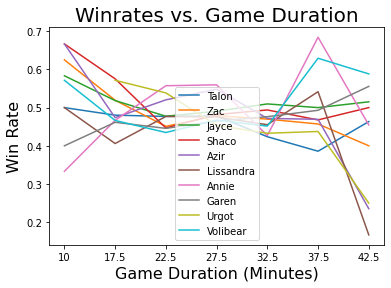

In [19]:
for i in range(80,90):
    champ = list(champs)[i]
    champ_data = wr_over_time_df[wr_over_time_df['champion'] == champ]
    plt.plot('duration', 'winrate', data=champ_data, label = champ)
    

plt.title("Winrates vs. Game Duration", size = 20)
plt.xlabel("Game Duration (Minutes)", size = 16)
plt.ylabel("Win Rate", size = 16)
plt.legend()

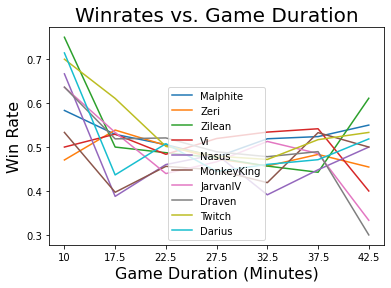

In [20]:
for i in range(90,100):
    champ = list(champs)[i]
    champ_data = wr_over_time_df[wr_over_time_df['champion'] == champ]
    plt.plot('duration', 'winrate', data=champ_data, label = champ)
    

plt.title("Winrates vs. Game Duration", size = 20)
plt.xlabel("Game Duration (Minutes)", size = 16)
plt.ylabel("Win Rate", size = 16)
plt.legend()

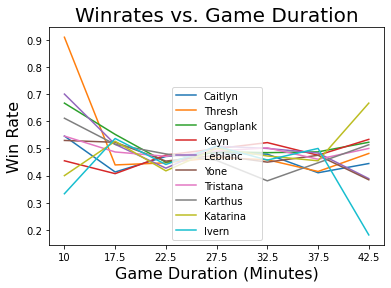

In [21]:
for i in range(100,110):
    champ = list(champs)[i]
    champ_data = wr_over_time_df[wr_over_time_df['champion'] == champ]
    plt.plot('duration', 'winrate', data=champ_data, label = champ)
    

plt.title("Winrates vs. Game Duration", size = 20)
plt.xlabel("Game Duration (Minutes)", size = 16)
plt.ylabel("Win Rate", size = 16)
plt.legend()

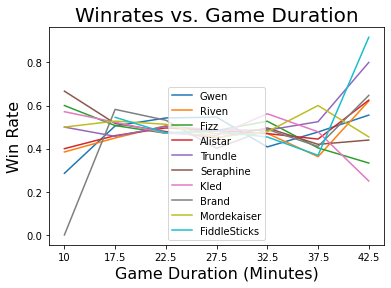

In [22]:
for i in range(110,120):
    champ = list(champs)[i]
    champ_data = wr_over_time_df[wr_over_time_df['champion'] == champ]
    plt.plot('duration', 'winrate', data=champ_data, label = champ)
    

plt.title("Winrates vs. Game Duration", size = 20)
plt.xlabel("Game Duration (Minutes)", size = 16)
plt.ylabel("Win Rate", size = 16)
plt.legend()

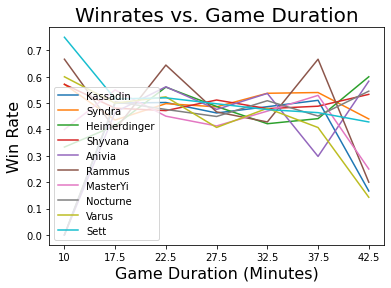

In [23]:
for i in range(120,130):
    champ = list(champs)[i]
    champ_data = wr_over_time_df[wr_over_time_df['champion'] == champ]
    plt.plot('duration', 'winrate', data=champ_data, label = champ)
    

plt.title("Winrates vs. Game Duration", size = 20)
plt.xlabel("Game Duration (Minutes)", size = 16)
plt.ylabel("Win Rate", size = 16)
plt.legend()

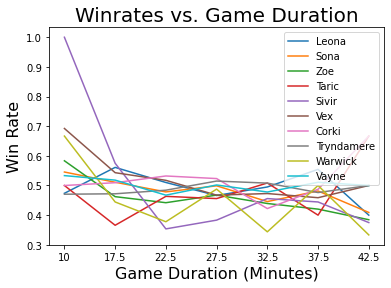

In [24]:
for i in range(130,140):
    champ = list(champs)[i]
    champ_data = wr_over_time_df[wr_over_time_df['champion'] == champ]
    plt.plot('duration', 'winrate', data=champ_data, label = champ)
    

plt.title("Winrates vs. Game Duration", size = 20)
plt.xlabel("Game Duration (Minutes)", size = 16)
plt.ylabel("Win Rate", size = 16)
plt.legend()

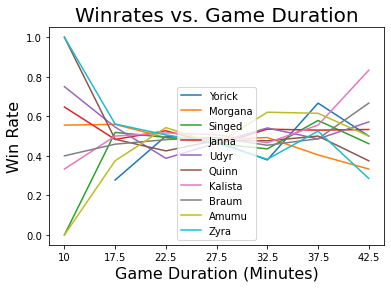

In [25]:
for i in range(140,150):
    champ = list(champs)[i]
    champ_data = wr_over_time_df[wr_over_time_df['champion'] == champ]
    plt.plot('duration', 'winrate', data=champ_data, label = champ)
    

plt.title("Winrates vs. Game Duration", size = 20)
plt.xlabel("Game Duration (Minutes)", size = 16)
plt.ylabel("Win Rate", size = 16)
plt.legend()

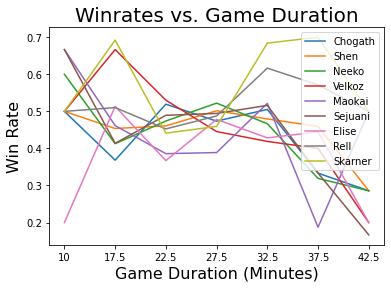

In [26]:
for i in range(150,159):
    champ = list(champs)[i]
    champ_data = wr_over_time_df[wr_over_time_df['champion'] == champ]
    plt.plot('duration', 'winrate', data=champ_data, label = champ)
    

plt.title("Winrates vs. Game Duration", size = 20)
plt.xlabel("Game Duration (Minutes)", size = 16)
plt.ylabel("Win Rate", size = 16)
plt.legend()

Looking at the graphs laid out it continues to be clear that in order for more thorough analysis to be done in the future we need to gather a larger sample set of games. The massive changes in winrate for each five minute interval especially amoungst those characters that have low pick rates clearly show that the conclusions we draw from this data are not likely to represent the population as closely as we would like. Nevertheless we push forward anyway.

One thing that we can see from these graphs is that there are some characters who have a general trend to their winrate over time. For example, in the 14th graph (the one that shows characters 140 through 150) we can see that the champion Zyra has a strong early game that falls off relatively linearly as the game goes on. Another character that fits a defined mould would be Gwen, shown in graph 11. She has a weak early game, transitions relatively well into an early mid game, then has a dip after which she seems to scale very well into the ultra late game.

One other thing that we could look at for exploratory analysis is the change in winrate that a character experiences by having any other character on its team. For this, we would need to look through each character and determine their winrate given that they have each other character as a teammate. The other team matters aswell though, so we should also find the change in winrate that comes from having each other character on the opposing team.

In [201]:

foo = {}

for champ in list(champs):
    foo[champ] = {}
    for champ2 in list(champs):
        foo[champ][f"ally{champ2}wins"] = 0
        foo[champ][f"ally{champ2}games"] = 0
        foo[champ][f"enemy{champ2}wins"] = 0
        foo[champ][f"enemy{champ2}games"] = 0

for row in match_df.iterrows():
    # For each row, calculate the winpercent for that year and then add it to a new list which will become our last column
    id = row[0]
    team1_champs = row[1]['team1_champs']
    team2_champs = row[1]['team2_champs']
    duration = row[1]['duration']
    version = row[1]['version']
    team1_win = row[1]['team1_win']
                   
    # For each character in team1, increment its wins and games for each ally on its team including itself (this should be equal to total winrate)
    for champ in team1_champs:
        for friendly in team1_champs:
            if team1_win == True:
                foo[champ][f"ally{friendly}wins"] = foo[champ][f"ally{friendly}wins"] + 1
            foo[champ][f"ally{friendly}games"] = foo[champ][f"ally{friendly}games"] + 1
            
        for enemy in team2_champs:
            if team1_win == True:
                foo[champ][f"enemy{enemy}wins"] = foo[champ][f"enemy{enemy}wins"] + 1
            foo[champ][f"enemy{enemy}games"] = foo[champ][f"enemy{enemy}games"] + 1
      
    
   #  For each character in team2, increment its wins and games for each ally on its team including itself (this should be equal to total winrate)            
    for champ in team2_champs:
        for friendly in team2_champs:
            if team1_win == False:
                foo[champ][f"ally{friendly}wins"] = foo[champ][f"ally{friendly}wins"] + 1
            foo[champ][f"ally{friendly}games"] = foo[champ][f"ally{friendly}games"] + 1
            
        for enemy in team1_champs:
            if team1_win == False:
                foo[champ][f"enemy{enemy}wins"] = foo[champ][f"enemy{enemy}wins"] + 1
            foo[champ][f"enemy{enemy}games"] = foo[champ][f"enemy{enemy}games"] + 1
   

Now that we have the wins and total number of games played for each champion with each other champion as its ally as well as its enemy we want to calculate the winrate for each of those situations.

In [202]:
for champ in foo:
    for champ2 in list(champs):
        # Calculate the winrate for having each champ as an enemy
        if foo[champ][f"enemy{champ2}games"] == 0:
            foo[champ][f"enemy{champ2}wr"] = np.nan
        else:
            foo[champ][f"enemy{champ2}wr"] = foo[champ][f"enemy{champ2}wins"] / foo[champ][f"enemy{champ2}games"]
            
        # Calculate the winrate for having each champ as an ally
        if foo[champ][f"ally{champ2}games"] == 0:
            foo[champ][f"ally{champ2}wr"] = np.nan
        else:
            foo[champ][f"ally{champ2}wr"] = foo[champ][f"ally{champ2}wins"] / foo[champ][f"ally{champ2}games"]

From the above code now we have the winrate associated with each character as well as their new winrate given that they have each other character on their team or against them. It is important to note that this method does not consider the winrate for each possible combination of allies and enemies. For one, that would be a bit more complicated to code up and write analysis for, but the problem is primarily that with our small sample size we dont have the dataset necessary to get more than one game at most for each combination. That would make any analysis we draw from this far to biased in favor of whatver singular game met each combination. It would be a very interesting next step to achieve given more time to collect a larger sample base of matches from which to draw team combinations and their associated winrates.

Next we need to do some more pre-processing to make our table easier to perform analysis with. In the code below we will make a new table where each row contains the winrates of each champion and their winrate with each other champion as an ally as well as an enemy. This way we can plot the changes in winrate associated with each pairing in order to see if some matchups or synergies stand out as being extra important.

In [203]:
combo_wr_df = pd.DataFrame(list(champs), columns=['champion'])

for champion in list(champs):
    ally_wr = []
    enemy_wr = []
    for row in combo_wr_df.iterrows():
        # For each row, calculate the winpercent for that year and then add it to a new list which will become our last column
        id = row[0]
        champ = row[1]['champion']
        ally_wr.append(foo[champ][f"ally{champion}wr"])
        enemy_wr.append(foo[champ][f"enemy{champion}wr"])
    combo_wr_df[f"ally{champion}wr"] = ally_wr
    combo_wr_df[f"enemy{champion}wr"] = enemy_wr

combo_wr_df

,champion,allyFiorawr,enemyFiorawr,allyKindredwr,enemyKindredwr,allyOriannawr,enemyOriannawr,allyLucianwr,enemyLucianwr,allyRenatawr,...,allyMaokaiwr,enemyMaokaiwr,allySejuaniwr,enemySejuaniwr,allyElisewr,enemyElisewr,allyRellwr,enemyRellwr,allySkarnerwr,enemySkarnerwr
0,Fiora,0.499542,NaN,0.556604,0.388889,0.418605,0.525000,0.465909,0.525253,0.527559,...,0.181818,0.461538,0.750000,0.619048,0.388889,0.428571,0.625000,0.392857,0.750000,0.500000
1,Kindred,0.556604,0.611111,0.540304,NaN,0.526316,0.560976,0.513333,0.565421,0.609091,...,0.750000,0.538462,0.666667,0.437500,1.000000,0.368421,0.625000,0.500000,0.333333,0.250000
2,Orianna,0.418605,0.475000,0.526316,0.439024,0.468217,NaN,0.448980,0.454545,0.486486,...,NaN,0.666667,0.800000,0.285714,0.600000,1.000000,0.250000,0.333333,NaN,1.000000
3,Lucian,0.465909,0.474747,0.513333,0.434579,0.448980,0.545455,0.502731,NaN,0.578947,...,0.500000,0.466667,0.580645,0.531250,0.500000,0.407407,0.444444,0.461538,0.636364,0.545455
4,Renata,0.527559,0.532110,0.609091,0.341880,0.486486,0.464286,0.578947,0.449664,0.540698,...,1.000000,1.000000,0.526316,0.461538,0.466667,0.523810,NaN,0.600000,0.714286,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,Maokai,0.181818,0.538462,0.750000,0.461538,NaN,0.333333,0.500000,0.533333,1.000000,...,0.530973,NaN,0.000000,1.000000,1.000000,0.000000,NaN,0.000000,1.000000,NaN
155,Sejuani,0.750000,0.380952,0.666667,0.562500,0.800000,0.714286,0.580645,0.468750,0.526316,...,0.000000,0.000000,0.457317,NaN,NaN,0.333333,0.250000,0.333333,NaN,0.000000
156,Elise,0.388889,0.571429,1.000000,0.631579,0.600000,0.000000,0.500000,0.592593,0.466667,...,1.000000,1.000000,NaN,0.666667,0.485246,NaN,NaN,1.000000,NaN,0.000000
157,Rell,0.625000,0.607143,0.625000,0.500000,0.250000,0.666667,0.444444,0.538462,NaN,...,NaN,1.000000,0.250000,0.666667,NaN,0.000000,0.542135,NaN,NaN,NaN


One thing that we have to be careful of with this dataset is the number of missing data values. This is caused by our subpar sample size which leads to there not being enough games for every character to be played with and against each other character even once, especially for the least popular champions. To get an idea of how many missing data values we have, the following code counts the number of NaN values in the table.

In [204]:
combo_wr_df.isna().sum().sum()

1167

1167 values is a lot of missing data, however relative to the size of our table it is less than you might expect. Given that we have 1167 missing values and 159*159*2 = 50562 total values in our table, the proportion of missing values is 0.0231 or about 2.31% of our data is missing. This is not what any reasonable person would call good, but its what we have so we need to make the best of it. Especially unfortunately for us, this missing data is considered **Missing Not at Random**, this means that the data itself has some affect on its likelihood of being missing from the dataset. In our case, less popular characters are less likely to be played and therefore have a greater likelihood of being missing. Part of being unpopular comes from a perception of being bad so it could be the case that characters with negative affects on winrate are picked less and therefore their own value affects their missingness. It could also be the case that there are known bad pairs, be that ally champions that have some sort of anti-synergy or picks that are specifically bad into other enemy champions. In both cases this would lead certain combinations of picks to be less likely to show up in our data because players are self selecting to remove those pairs from the match history due to some perceived notion of poor performance.

There are two main ways that we can choose to deal with this missing data. One, we could ignore it for the sake of our analysis. In the case of a violin plot this might be a good idea because we don't want any imputation making it seem like the distribution is less spread out than it would be if we had the whole population worth of data. On the other hand, because the data is missing not at random we cannot just ignore it, to do so would be to violate the understanding that the pairs that do not have data associated with them may have been missing because of some perceived weakness. The second option is to perform some kind of imputation. **Imputation** is the process of generating values to replace our missing data. There are two main forms of imputation, single imputation and multiple imputation. In **single imputation** we generate one new value based on some collection of the other data in our set, for example we could take the missing value to be equal to the primary champion's average winrate which would assume that the pair has no affect on the winrate. In **multiple imputation** some noise is added to our guess at the missing value and many alternate new values are proposed. We then perform separate analysis on each of the new datasets created by our selection of imputed values and then combine the analysis at the end. Multiple imputation is much prefered over single imputation because it adds in some of the uncertainty that we have regarding whether our guess of the missing value. However given the size of this dataset my computer would not be able to handle running multiple imputation well so we will stick with an average single imputation, as in we will take the missing value to be the average of the two average winrates for each of the champions in the pair. If the paired champion is an ally we will take the missing win rate to be equal to ```(champ1_wr + champ2_wr) / 2``` and if the paired champ is an enemy we will take the winrate to be equal to ```(champ1_wr + (1-champ2_wr)) / 2``` because we want the second champion to lose in this case. The use of multiple imputation at this step rather than single is an improvement that could be made to improve the quality of our analysis. Also importantly, not all of the NaN's will be removed by this process. In League the same character cannot be picked more than once by either team. Therefore for each character we would expect two NaNs because each champion cannot have itself as an ally or an enemy.

In [205]:
for row in combo_wr_df.iterrows():
    id = row[0]
    champ = row[1]['champion']
    for champ2 in list(champs):
        if pd.isna(row[1][f"ally{champ2}wr"]) and champ != champ2:
            combo_wr_df.at[id, f"ally{champ2}wr"] = (champ_wr[champ] + champ_wr[champ2]) / 2
        if pd.isna(row[1][f"enemy{champ2}wr"]) and champ != champ2:
            combo_wr_df.at[id, f"enemy{champ2}wr"] = (champ_wr[champ] + (1 - champ_wr[champ2])) / 2

combo_wr_df

,champion,allyFiorawr,enemyFiorawr,allyKindredwr,enemyKindredwr,allyOriannawr,enemyOriannawr,allyLucianwr,enemyLucianwr,allyRenatawr,...,allyMaokaiwr,enemyMaokaiwr,allySejuaniwr,enemySejuaniwr,allyElisewr,enemyElisewr,allyRellwr,enemyRellwr,allySkarnerwr,enemySkarnerwr
0,Fiora,0.499542,NaN,0.556604,0.388889,0.418605,0.525000,0.465909,0.525253,0.527559,...,0.181818,0.461538,0.750000,0.619048,0.388889,0.428571,0.625000,0.392857,0.750000,0.500000
1,Kindred,0.556604,0.611111,0.540304,NaN,0.526316,0.560976,0.513333,0.565421,0.609091,...,0.750000,0.538462,0.666667,0.437500,1.000000,0.368421,0.625000,0.500000,0.333333,0.250000
2,Orianna,0.418605,0.475000,0.526316,0.439024,0.468217,NaN,0.448980,0.454545,0.486486,...,0.499595,0.666667,0.800000,0.285714,0.600000,1.000000,0.250000,0.333333,0.513275,1.000000
3,Lucian,0.465909,0.474747,0.513333,0.434579,0.448980,0.545455,0.502731,NaN,0.578947,...,0.500000,0.466667,0.580645,0.531250,0.500000,0.407407,0.444444,0.461538,0.636364,0.545455
4,Renata,0.527559,0.532110,0.609091,0.341880,0.486486,0.464286,0.578947,0.449664,0.540698,...,1.000000,1.000000,0.526316,0.461538,0.466667,0.523810,0.541416,0.600000,0.714286,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,Maokai,0.181818,0.538462,0.750000,0.461538,0.499595,0.333333,0.500000,0.533333,1.000000,...,0.530973,NaN,0.000000,1.000000,1.000000,0.000000,0.536554,0.000000,1.000000,0.486320
155,Sejuani,0.750000,0.380952,0.666667,0.562500,0.800000,0.714286,0.580645,0.468750,0.526316,...,0.000000,0.000000,0.457317,NaN,0.471281,0.333333,0.250000,0.333333,0.507825,0.000000
156,Elise,0.388889,0.571429,1.000000,0.631579,0.600000,0.000000,0.500000,0.592593,0.466667,...,1.000000,1.000000,0.471281,0.666667,0.485246,NaN,0.513690,1.000000,0.521790,0.000000
157,Rell,0.625000,0.607143,0.625000,0.500000,0.250000,0.666667,0.444444,0.538462,0.541416,...,0.536554,1.000000,0.250000,0.666667,0.513690,0.000000,0.542135,NaN,0.550234,0.491901


Now that we have a newly imputed table of champion pair winrates we should graph something interesting to finish off our exploratory analysis. A graph that can be useful for showing the distribution of winrate changes is a violin plot. As an example we will make one plot for the champion **Graves** because he is the character played in the most games for our dataset and therefore his violin plot will hopefully have a reasonable sample set for each other character pairing. Of course these graphs can be altered for any character available, just edit the entries in the code that read "Graves" for the name of any character whose interaction violin plots you wish to graph. For the graphs below, we want to show the violin plot the describes the distribution of the changes in Graves's winrate that comes from each ally and enemy parir. If the plots are perfectly normally distributed this would suggest that there is no sort of special counter match up or synergistic affect that comes from any character specifically, and more that the winrates of characters meld as one would expect from random chance. On the other hand, if there are bulbous portions of the violin plot, it would suggest that some group of characters have something more going on with their paired affects that we should look into further.

In [206]:
ally_wr_diff = []
enemy_wr_diff = []
graves_row = combo_wr_df.loc[combo_wr_df['champion'] == "Graves"]

for champ in list(champs):
    # print(graves_row[f"ally{champ}wr"][53])
    ally_wr_diff.append(graves_row[f"ally{champ}wr"][53] - champ_wr["Graves"])
    enemy_wr_diff.append(graves_row[f"enemy{champ}wr"][53] - champ_wr["Graves"])
    
ally_wr_diff_df = pd.DataFrame({'ally': champs,
     'ally_wr_diff': ally_wr_diff
    })
enemy_wr_diff_df = pd.DataFrame({'enemy': champs,
     'enemy_wr_diff': enemy_wr_diff
    })

In [211]:
enemy_wr_diff_df.dtypes

enemy             object
enemy_wr_diff    float64
dtype: object

Text(0.5, 1.0, 'Graves Ally Winrate Change Violin Plot')

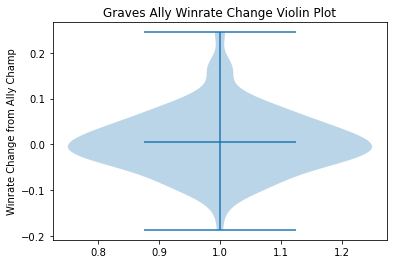

In [213]:
# Violin plot for ally wr changes
fig, ax = plt.subplots()
ax.violinplot(ally_wr_diff_df['ally_wr_diff'].dropna(),showmeans=True)
ax.set_ylabel("Winrate Change from Ally Champ")
ax.set_title("Graves Ally Winrate Change Violin Plot")

Text(0.5, 1.0, 'Graves Enemy Winrate Change Violin Plot')

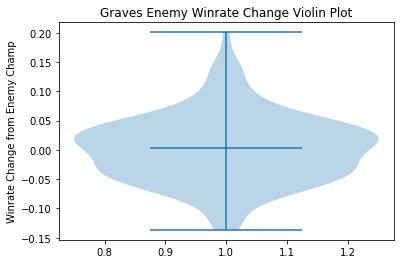

In [212]:
# Violin plot for enemy wr changes
fig, ax = plt.subplots()
ax.violinplot(enemy_wr_diff_df['enemy_wr_diff'].dropna(),showmeans=True)
ax.set_ylabel("Winrate Change from Enemy Champ")
ax.set_title("Graves Enemy Winrate Change Violin Plot")

The ally violin plot is very close to a perfect normal distribution with a small deformity on the positive side. This suggests that the vast majority of characters are affecting the winrate as you would expect from their own, but there is a small group that may be having some synergistic affect. In the case of the enemy winrate plot it is a messier distribution, but nevertheless it is approximately normal. There is however an abnormal increase in proportion of the distribution on the negative side which sugests that there are counter matchups which decrease the winrate more than they would given an perfect averaging of the two characters winrates.

While these two graphs are not data enough on their own to prove any kind of statistical signifigance to the theory that some characters have synergistic or counter potential with eachother, it is cause enough to perform further analysis.

We can also make a violin plot for the difference in the winrate calculate for the pair and the expected winrate for the pair. In this case the expected winrate is equal to the average of their winrates for allies and the average of the current characters winrate and their opponents loss rate.

In [214]:
ally_wr_exp_diff = []
enemy_wr_exp_diff = []
ally_expected_wr = []
enemy_expected_wr = []
actual_wr = []
graves_row = combo_wr_df.loc[combo_wr_df['champion'] == "Graves"]

for champ in list(champs):
    # print(graves_row[f"ally{champ}wr"][53])
    actual_wr.append(graves_row[f"ally{champ}wr"][53])
    ally_wr_exp_diff.append(graves_row[f"ally{champ}wr"][53] - ((champ_wr["Graves"] + champ_wr[champ]) / 2))
    enemy_wr_exp_diff.append(graves_row[f"ally{champ}wr"][53] - ((champ_wr["Graves"] + 1 - champ_wr[champ]) / 2))
    ally_expected_wr.append(((champ_wr["Graves"] + champ_wr[champ]) / 2))
    enemy_expected_wr.append(((champ_wr["Graves"] + 1 - champ_wr[champ]) / 2))
    
wr_exp_diff_df = pd.DataFrame({'other_champ': champs,
     'actual_wr' : actual_wr,
     'ally_wr_exp_diff': ally_wr_exp_diff,
     'ally_expected_wr': ally_expected_wr,
     'enemy_wr_exp_diff': enemy_wr_exp_diff,
     'enemy_expected_wr': enemy_expected_wr
    })
wr_exp_diff_df

,other_champ,actual_wr,ally_wr_exp_diff,ally_expected_wr,enemy_wr_exp_diff,enemy_expected_wr
0,Fiora,0.511962,0.009679,0.502282,0.009221,0.502741
1,Kindred,0.420000,-0.102664,0.522664,-0.062360,0.482360
2,Orianna,0.400000,-0.086620,0.486620,-0.118403,0.518403
3,Lucian,0.498542,-0.005335,0.503877,-0.002604,0.501146
4,Renata,0.567347,0.044487,0.522860,0.085184,0.482163
...,...,...,...,...,...,...
154,Maokai,0.466667,-0.051332,0.517998,-0.020358,0.487025
155,Sejuani,0.555556,0.074386,0.481170,0.031703,0.523853
156,Elise,0.583333,0.088199,0.495134,0.073445,0.509889
157,Rell,0.511628,-0.011951,0.523579,0.030184,0.481444


Text(0.5, 1.0, 'Graves Ally Expected Winrate Change')

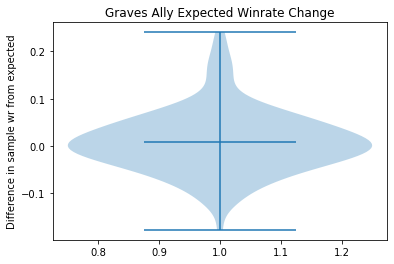

In [215]:
# Violin plot for ally wr changes
fig, ax = plt.subplots()
ax.violinplot(wr_exp_diff_df['ally_wr_exp_diff'],showmeans=True)
ax.set_ylabel("Difference in sample wr from expected")
ax.set_title("Graves Ally Expected Winrate Change")

Text(0.5, 1.0, 'Graves Enemy Expected Winrate Change')

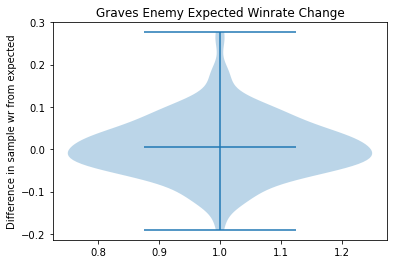

In [216]:
# Violin plot for enemy wr changes
fig, ax = plt.subplots()
ax.violinplot(wr_exp_diff_df['enemy_wr_exp_diff'],showmeans=True)
ax.set_ylabel("Difference in sample wr from expected")
ax.set_title("Graves Enemy Expected Winrate Change")

The expected winrate changes are not quite as in support of our belief in synergistic affects as they might look at first glance. From both plots it seems that the average difference between the expected winrate and the actual winrate is 0. Both plots are also close to textbook normal distributions with the tail ends of each distribution getting a little wonky. We would expect that wonkyness however because of the size of our sample and the variance that comes with a small set of games. We would also expect a greater distribution around 0 because when we imputed the missing values we used the expected winrate, so each of the imputed points are generating evidence to suggest that the expected winrate calculation does a good job representing the winrate distribution. The only way to go about fixing this is to have more data. It could also just be the case that Graves specifically is a character without much in the way of synergy or counters and therefore looking at him specifically in this plot is misleading us as to the nature of the dataset writ large.

**Analysis and Hypothesis Testing**

The next step for us is to perform some more concrete analysis to determine if there is a statistically signifigant difference in the winrates of characters that we could ascribe to a synergistic or counter effect. The analysis that we will be performing is called a **hypothesis test**. This is a statistical test that determines the probability of our data coming out the way it did randomly given some assumed condition which we call the **null hypothesis** (Denoted H<sub>0</sub>). In our case, the null hypothesis will be that no combination of characters has some extra affect on the primary chamption's winrate beyond averaging their winrates. Our **alternative hypothesis** (Denoted H<sub>1</sub>) is the necessarily that there is some x-factor of synergy or counter potential from other picks. We will consider that we have enough evidence to reject the null hypothesis if the **p-value**, the result of our statistical test, is less than 0.5, meaning that our data has a 5% chance or less to come out as extreme as it did given that the null hypothesis is true.

For the case of this data we will use a **2 Sided T Test**. This is a statistical test that finds the probability that some sample of data is less than or greater than some range of values. For our case, this means that we will be testing if the average difference between the expected and actual paired winrates are within some small range around 0. For our data we are going to separately find the p-value for the distibution of ally winrate changes and enemy winrate changes. This should give us an idea of whether your teammates character choices matter or your opponents as they could be different in their effect. The null hypothesis for the ally test is that a character having a specific ally champion does not affect the winrate more than averaging their winrates together. For the enemy test it is the same hypothesis just with the enemy character being a specific champion. Naturally the two alternative hypothesis are that the specific champion, be they ally or enemy, does have more of an affect on the winrate than a simple average. The code below construncts two new DataFrames to help us out with this task. It calculates the expected winrate, actual winrate, and the difference between them for each possible champion to champion ally and enemy pair.

In [220]:
champ1_lst = []
champ2_lst = []
expected_wr = []
actual_wr = []
wr_diff = []
for row in combo_wr_df.iterrows():
    for champ2 in list(champs):
        id = row[0]
        champ1 = row[1]['champion']
        
        # Duplicates not allowed so including them would just skew the data towards the expected value being correct
        if champ1 == champ2:
            continue
        
        # Get the ally information
        champ1_lst.append(champ1)
        champ2_lst.append(champ2)
        expected_wr.append((champ_wr[champ] + champ_wr[champ2]) / 2)
        actual_wr.append(combo_wr_df.at[id, f"ally{champ2}wr"])
        wr_diff.append(combo_wr_df.at[id, f"ally{champ2}wr"] - ((champ_wr[champ] + champ_wr[champ2]) / 2))

ally_wr_exp_diff_df = pd.DataFrame({'champion1': champ1_lst,
     'champion2' : champ2_lst,
     'actual_wr' : actual_wr,
     'expected_wr': expected_wr,
     'wr_diff' : wr_diff
    })
ally_wr_exp_diff_df

,champion1,champion2,actual_wr,expected_wr,wr_diff
0,Fiora,Kindred,0.556604,0.549319,0.007285
1,Fiora,Orianna,0.418605,0.513275,-0.094671
2,Fiora,Lucian,0.465909,0.530532,-0.064623
3,Fiora,Renata,0.527559,0.549516,-0.021956
4,Fiora,Gragas,0.451613,0.531061,-0.079448
...,...,...,...,...,...
25117,Skarner,Velkoz,0.666667,0.510170,0.156497
25118,Skarner,Maokai,1.000000,0.544653,0.455347
25119,Skarner,Sejuani,0.507825,0.507825,0.000000
25120,Skarner,Elise,0.521790,0.521790,0.000000


In [221]:
champ1_lst = []
champ2_lst = []
expected_wr = []
actual_wr = []
wr_diff = []

# Get the data for enemy pairs
for row in combo_wr_df.iterrows():
    for champ2 in list(champs):
        id = row[0]
        champ1 = row[1]['champion']
        
        # Duplicates not allowed so including them would just skew the data towards the expected value being correct
        if champ1 == champ2:
            continue  
        
        # Get the enemy information
        champ1_lst.append(champ1)
        champ2_lst.append(champ2)
        expected_wr.append((champ_wr[champ] + (1 - champ_wr[champ2])) / 2)
        actual_wr.append(combo_wr_df.at[id, f"enemy{champ2}wr"])
        wr_diff.append(combo_wr_df.at[id, f"enemy{champ2}wr"] - ((champ_wr[champ] + (1 - champ_wr[champ2])) / 2))    
        
        
enemy_wr_exp_diff_df = pd.DataFrame({'champion1': champ1_lst,
     'champion2' : champ2_lst,
     'actual_wr' : actual_wr,
     'expected_wr': expected_wr,
     'wr_diff' : wr_diff
    })
enemy_wr_exp_diff_df

,champion1,champion2,actual_wr,expected_wr,wr_diff
0,Fiora,Kindred,0.388889,0.509015,-0.120126
1,Fiora,Orianna,0.525000,0.545058,-0.020058
2,Fiora,Lucian,0.525253,0.527801,-0.002549
3,Fiora,Renata,0.467890,0.508818,-0.040928
4,Fiora,Gragas,0.468085,0.527273,-0.059188
...,...,...,...,...,...
25117,Skarner,Velkoz,1.000000,0.548164,0.451836
25118,Skarner,Maokai,0.513680,0.513680,0.000000
25119,Skarner,Sejuani,1.000000,0.550508,0.449492
25120,Skarner,Elise,1.000000,0.536544,0.463456


Below are the violin plots for the difference between expected and actual winrates for all of the pairs for both allies and enemies. These likely should have been created earlier in our data visualization stage but at the time I didn't realize they would be useful. Now that we are performing analysis on the data that these plots describe I have plotted them for a clearer understanding of our dataset. They almost have a pointy normal distribution going on in the middle of the plot, centered around 0 as we would expect. However they both have large pockets of differences on the extreme ends. This suggests that some characters are not described very well by the naive average approach that we took. This could be because those characters that make those points have some kind of strong synergy or counter potential, or it could mean that our sample size is small enough that pairs with few games have calculated winrates that dont match the population well.

Text(0.5, 1.0, 'Ally Expected Winrate Change')

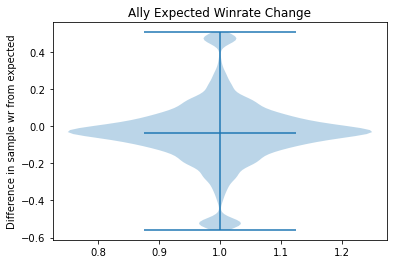

In [226]:
# Violin plot for ally wr changes
fig, ax = plt.subplots()
ax.violinplot(ally_wr_exp_diff_df['wr_diff'],showmeans=True)
ax.set_ylabel("Difference in sample wr from expected")
ax.set_title("Ally Expected Winrate Change")

Text(0.5, 1.0, 'Enemy Expected Winrate Change')

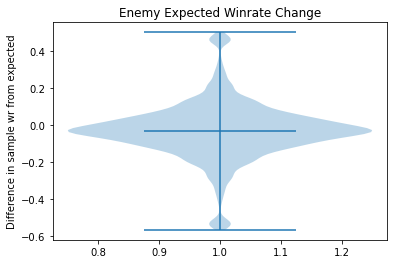

In [225]:
# Violin plot for enemy wr changes
fig, ax = plt.subplots()
ax.violinplot(enemy_wr_exp_diff_df['wr_diff'],showmeans=True)
ax.set_ylabel("Difference in sample wr from expected")
ax.set_title("Enemy Expected Winrate Change")

The lines below run a 2 sided t test using scipy to compute the p-values for ally composition as well as enemy composition. Remeber that if the p-value is less than 0.5 we have statistically signifigant evidence to reject the null hypothesis that there is no x-factor for the winrate of a character based on other present characters.

In [222]:
from scipy import stats
popmean = 0 # Use the mean as zero, which is the value that would occur if the expected value was correct
scipy.stats.ttest_1samp(ally_wr_exp_diff_df['wr_diff'], popmean, axis=0, nan_policy='propagate', alternative='two-sided')

Ttest_1sampResult(statistic=-32.610404272982635, pvalue=1.6924899093733628e-228)

In [223]:
popmean = 0 # Use the mean as zero, which is the value that would occur if the expected value was correct
scipy.stats.ttest_1samp(enemy_wr_exp_diff_df['wr_diff'], popmean, axis=0, nan_policy='propagate', alternative='two-sided')

Ttest_1sampResult(statistic=-32.240182668936335, pvalue=1.7271889876730746e-223)

In the case of ally expected winrate differences we got a p-value of 1.6924899093733628e-228 which means that data as extreme or more extreme as our sample could occur randomly about 0% of the time given that the mean for the difference is 0. This value is less than 0.05 and therefore we do have statistically signifigant evidence to reject the null hypothesis. In the case of enemy expected winrate differences the p-value was 1.7271889876730746e-223 which means that data as extreme or more extreme as our sample could occur randomly about 0% of the time given that the mean for the difference is 0. From this data and the tests done we have extreme statistical evidence that the pairs of ally and enemy champions have an affect on a characters winrate beyond what we would expect from a naive average of their win rates. 

**Communication of Insights**

It is surprising that the data came back so conclusively with such small p-values to suggest that champion pairings matter to the winrate. I would have assumed that there would be some affect, but I would have expected p-values much further away from zero. There are a few explanations for why I believed this. The first is that the method we used to impute missing data points was to use the simple average described above. This would have added more datapoints to the area of the test distribution around zero because necessarily all of the added values have no difference in their expected winrate and the "actual" winrate which was imputed. Another option is that characters could have a roughly equivalent distribution of counter picks and things that they counter (or in the case of allies helpful and unhelpful picks). This would mean that individual champions might raise or lower the winrate of the primary character more than an average would suggest, but that in the aggregate this information is lossed as they balance out. It could have also been the case that players self select out of these matchups that are pressumed bad for one party and that therefore those datapoints that would show an affect greater than the expected winrate are selected out by the players and not expressed. Necessarily the matchups that improve winrate would be less likely to see in our data as well because your opponent is likely going to self select out of what they consider a bad match up.

One explanation for why it seems that our analysis suggests that the pairs matter as much as they do is that our sample size is not as good as it could be. There are many pairs of characters who have fewer than 5 games played together, even combining ally and enemy games. This means that each indiviudal game is much more important to the winrate of the pair than it should be and so one greater or fewer win would lead to a drastic change in the winrate. Therefore those pairs that have few games will be considered not described well by the naive average winrate calculation in part because their actual value cant come close to the expected one by nature of the number of games those pairs have played. Because of this problem with sample size we need to be careful not to take this analysis as gospel and realize that this evidence needs to be backed up further by more exhaustive study with a much larger sample size. Preferably the whole population since it is possible to aquire the match data for every match played in the current season, it would just take more computing time for requests than we have available. This problem showcases a major aspect of the data science pipeline, that is that the pipeline is not some straight path that leads from a question to an answer, but a circular wibbly wobbly looping construct wherein new questions are asked, new data aquired, new visualizations done, and right back to new questions. Just because a step has been "completed" does not mean that you can't go back to improve a previous component or need to do something from a previous step because there is some question you didn't know you had or data you didn't know you needed.

Aside from the previously noted problems with our analysis, what do these numbers suggest? Well for starters we have some evidence to believe that the composition of teams does have an statistically signifigant affect on the outcome of a game. The key take-away here is that when picking your own character in a game, assuming you want to maximize your chance of success, you should take into account both the enemy team and your own team's picked characters. This is close to common knowledge amoungst the player base, but now there is some statistical evidence to suggest that this is true for real, and not just a delusion of the community.